<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Mads/vis_AML_IceCores_combined_train_on_everything_resnetstuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
from load_data import training_set_RGB
from Models import make_autoencoder
!pip install pyyaml h5py 
!pip install umap-learn

Streaming output truncated to the last 5000 lines.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Insoluables_T

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
#import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state=37)
train = training_set_RGB(train_df, sup_im_path)
test = training_set_RGB(test_df, sup_im_path)

In [4]:
# save image_size
im_e, _, _ = train.__getitem__(0)
image_size = im_e.shape[0]
image_size

128

In [5]:
train_size = len(train.labels)
test_size = len(test.labels)

In [15]:
def make_NN_conv():
  image_size = 128

  conv_input = keras.Input(shape=(image_size,image_size,3))
  x = ResNet50(input_shape=(image_size, image_size,3), include_top=False, weights='imagenet', pooling='max')(conv_input)
  #x = keras.layers.Flatten()(x)
  #x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  #x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  conv_output = keras.layers.Dense(128)(x)

  meta_input = keras.Input(shape=(34))
  x = keras.layers.Dense(128, activation='relu')(meta_input)
  #x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  #x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  meta_output = keras.layers.Dense(32, activation='relu')(x)

  combined = keras.layers.concatenate([conv_output, meta_output])

  x = keras.layers.Dense(96, activation='relu')(combined)
  #x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dense(40, activation='relu')(x)
  #x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  x = keras.layers.Dropout(0.2)(x)
  #x = keras.layers.BatchNormalization(momentum=0.9, center=True, scale=True)(x)
  combined_output = keras.layers.Dense(7, activation='softmax')(x)

  model = keras.Model([conv_input, meta_input], combined_output)

  model.summary()

  opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

  model.compile(opt, loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

  return model

In [16]:
NN = make_NN_conv()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 resnet50 (Functional)          (None, 2048)         23587712    ['input_4[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 128)          4480        ['input_6[0][0]']          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
from keras.utils.vis_utils import plot_model, model_to_dot

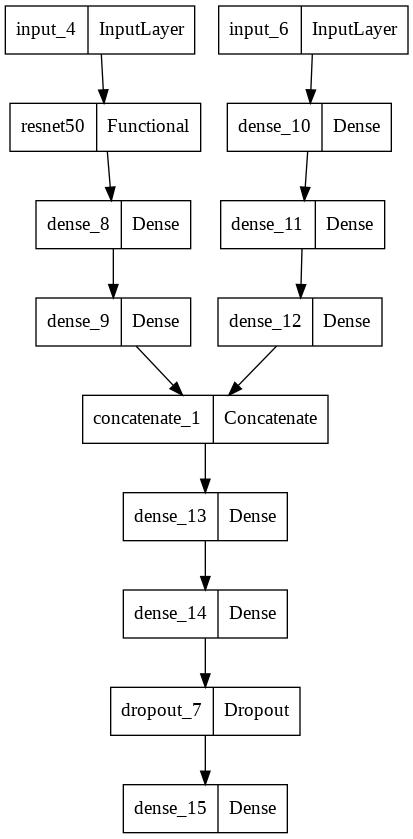

In [22]:
plot_model(NN)

In [11]:
train_increment = 5
#nr_trains = train_size//train_increment
nr_trains=1
points_left_over = train_size % train_increment

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

index_count = 0
for i in range(nr_trains):
  x_im = []
  x_lab = []
  x_feat = []
  for j in range(train_increment):
    im, lab, feat = train.__getitem__(index_count)
    index_count += 1
    x_im.append(im)
    x_lab.append(lab)
    x_feat.append(feat)

  x_im = np.array(x_im)
  x_lab = np.array(x_lab)
  x_feat = np.array(x_feat)

  NN.fit([x_im, x_feat], x_lab, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
1/1 [==============================] - 17s 17s/step - loss: 3.7802 - accuracy: 0.0000e+00 - val_loss: 2.1486 - val_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 3.0274 - accuracy: 0.0000e+00 - val_loss: 2.1968 - val_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 3.1628 - accuracy: 0.0000e+00 - val_loss: 3.2315 - val_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 1s 1s/step - loss: 2.5433 - accuracy: 0.0000e+00 - val_loss: 3.5471 - val_accuracy: 0.0000e+00


In [12]:
!pip install ann-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=be58c03067e833e4ddabec526a81d6240b3d5bc5c124f5a1023bb70c10c3ce1f
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


In [14]:
from ann_visualizer.visualize import ann_viz;
#Build your model here
ann_viz(NN)

ValueError: ignored

In [21]:

import schemdraw
from schemdraw.flow import *

with schemdraw.Drawing() as d:
    d+= Start().label("Start")
    d+= Arrow().down(d.unit/2)
    
    #Input the string 
    d+= Data(w = 4).label("Enter a string:\n string")
    d+= Arrow().down(d.unit/2)
    
    #Reverse the string
    d+= Box(w = 4).label("Reverse the string:\n reverse_string")
    d+= Arrow().down(d.unit/2)
    
    #Check if string and reverse_string are same
    d+= (decision := Decision(w = 5, h= 5,
                       S = "True",
                        E = "False").label("Is \n string\n == \nreverse_string?"))
    
    #If True
    d+= Arrow().length(d.unit/2)
    d+= (true := Box(w = 5).label("string is a palindrome."))
    d+= Arrow().length(d.unit/2)
    
    #End program
    d+= (end := Ellipse().label("End"))
    
    #If False. Start the arrow from East of decision box
    d+= Arrow().right(d.unit).at(decision.E)
    
    #false is referring to the box where string is not a palindrome.
    d+= (false := Box(w = 5).label("string is not\n a palindrome."))
    
    #Add a downward arrow from the South of false box 
    d+= Arrow().down(d.unit*2.5).at(false.S)
    
    #Extend the arrow to reach the end of the program
    d+= Arrow().left(d.unit*2.15)
    d.save("output/palindrome flowchart.jpeg", dpi = 300)
view raw
flowchart_palindrome hosted with ❤ by GitHub


SyntaxError: ignored